<a href="https://colab.research.google.com/github/Bobrinik/personal-finance/blob/master/Finances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [13]:
import pandas as pd
import os

# Set index_col to false because else it use first column as index
df = pd.read_csv('My Drive/rbc_bank/rbc_data.csv', index_col=False, encoding = "ISO-8859-1")

# We rename columns here
df.columns = [
  'account_type', 
  'account_number',
  'date_of_transaction',
  'check_number',
  'description',
  'extra_description',
  'CAD',
  'USD']
df.date_of_transaction = pd.to_datetime(df.date_of_transaction)
df

,account_type,account_number,date_of_transaction,check_number,description,extra_description,CAD,USD
0,MasterCard,5.420000e+15,2019-11-17,NaN,PROVIGO MICHEL LEFEBVR MONTREAL QC,NaN,-69.42,NaN
1,MasterCard,5.420000e+15,2019-11-19,NaN,PHARMAPRIX #1800 MONTREAL QC,NaN,-6.35,NaN
2,MasterCard,5.420000e+15,2019-11-19,NaN,TIM HORTONS #4268 MONTREAL QC,NaN,-8.95,NaN
3,MasterCard,5.420000e+15,2019-11-20,NaN,PHARMAPRIX #1800 MONTREAL QC,NaN,-13.41,NaN
4,MasterCard,5.420000e+15,2019-11-30,NaN,TIM HORTONS #5095 MONTREAL QC,NaN,-6.64,NaN
5,MasterCard,5.420000e+15,2019-12-01,NaN,PROVIGO MICHEL LEFEBVR MONTREAL QC,NaN,-34.70,NaN
6,MasterCard,5.420000e+15,2019-12-02,NaN,PHARMAPRIX #1800 MONTREAL QC,NaN,-16.99,NaN
7,MasterCard,5.420000e+15,2019-12-03,NaN,universel dejeuner,NaN,-16.99,NaN
8,MasterCard,5.420000e+15,2019-12-04,NaN,club insiders,NaN,-16.99,NaN
9,MasterCard,5.420000e+15,2019-12-05,NaN,marche topetta,NaN,-16.99,NaN


In [0]:
# NOTE: Here we are only selecting spendings that have been made from the MasterCard
from datetime import datetime

date_to_choose = (df.date_of_transaction > datetime(2019,12,1)) & (df.date_of_transaction < datetime(2019,12,31))
account_type = df.account_type == 'MasterCard'
filter_out_description = df.description != 'PAYMENT - THANK YOU / PAIEMENT - MERCI'

monthly_transactions = df[date_to_choose & account_type & filter_out_description]

In [19]:
# Location contains place where we spent the money
monthly_transactions['location'] = monthly_transactions.description

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Financial data
- What is the list of ten most expensive things?
- On what days of the week do I spend my money?


In [20]:
# 10 Most expensive things
top = monthly_transactions.sort_values('CAD').head(10)
top

,account_type,account_number,date_of_transaction,check_number,description,extra_description,CAD,USD,day,location
6,MasterCard,5.420000e+15,2019-12-02,NaN,PHARMAPRIX #1800 MONTREAL QC,NaN,-16.99,NaN,Monday,PHARMAPRIX #1800 MONTREAL QC
7,MasterCard,5.420000e+15,2019-12-03,NaN,universel dejeuner,NaN,-16.99,NaN,Tuesday,universel dejeuner
8,MasterCard,5.420000e+15,2019-12-04,NaN,club insiders,NaN,-16.99,NaN,Wednesday,club insiders
9,MasterCard,5.420000e+15,2019-12-05,NaN,marche topetta,NaN,-16.99,NaN,Thursday,marche topetta
10,MasterCard,5.420000e+15,2019-12-06,NaN,dollarama,NaN,-16.99,NaN,Friday,dollarama
11,MasterCard,5.420000e+15,2019-12-07,NaN,sports experts,NaN,-16.99,NaN,Saturday,sports experts
12,MasterCard,5.420000e+15,2019-12-08,NaN,saq,NaN,-16.99,NaN,Sunday,saq
13,MasterCard,5.420000e+15,2019-12-09,NaN,stm,NaN,-16.99,NaN,Monday,stm
14,MasterCard,5.420000e+15,2019-12-10,NaN,fido,NaN,-16.99,NaN,Tuesday,fido
15,MasterCard,5.420000e+15,2019-12-11,NaN,shahdad heydari,NaN,-16.99,NaN,Wednesday,shahdad heydari


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Number of transactions per day of the week')

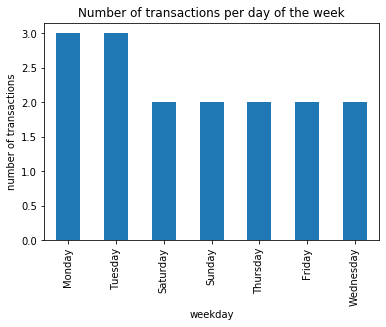

In [21]:
import calendar
import matplotlib.pyplot as plt
monthly_transactions["day"] = monthly_transactions.date_of_transaction.apply(lambda x: calendar.day_name[x.weekday()])

serie = monthly_transactions["day"].value_counts()
serie.plot(kind='bar')
plt.xlabel('weekday')
plt.ylabel('number of transactions')
plt.title('Number of transactions per day of the week')

In [40]:
spendings_per_location = monthly_transactions.groupby('location').CAD.sum().reset_index()
spendings_per_location.sort_values('CAD')

,location,CAD
0,PHARMAPRIX #1800 MONTREAL QC,-16.99
1,amazon,-16.99
2,apple.com,-16.99
3,best buy,-16.99
4,club insiders,-16.99
5,dollarama,-16.99
6,fido,-16.99
7,marche topetta,-16.99
8,pragmatic programmer,-16.99
9,rent,-16.99


## Budget categories
 Categories provided by RBC are not the same ones I use for my montly planning.
 So here I propose to use a simple classifier based on string matching.

In [0]:
import re

categories = [
  ('restaurants', r'(\buniversel dejeuner\b|\bseoul chako\b|\ba&w\b|\bchef on call\b|\bcafe\b|\bjuliette\b|\bsecond cup\b|\bstation berlin\b|yokato yokabai|tim hortons|taverne midway|restaurant|grillades|thai express|\bburger\b|\bboustan\b|\bramen\b)'),
  ('entertainment', r'(club insiders|sq *sq *impro|\bfamous player\b)'),
  ('grocery', r'(lindt|marche topetta|provigo|alimentation|marche|\bprovi-soir\b)'),
  ('house', r'(jean coutu|dollarama)'),
  ('clothes', r'(sports experts|h&m|jj ste-catherine)'),
  ('alcohol', r'^saq'),
  ('transport', r'(\bstm\b|\buber\b)'),
  ('utilities', r'(fido|nautilus plus|papeterie nota|amagicom|coinamatic|pharmaprix|\bcoiffure\b|\bbonlook\b|\buniprix\b)'),
  ('medical', r'shahdad heydari'),
  ('online_shopping', r'\bamazon\b|\bindigo\b'),
  ('electronics', r'\bbest buy\b'),
  ('rent', r'\brent\b'),
  ('education', r'(pragmatic programmers|feedly|codecademy)'),
  ('saving', r'trouvepargne'),
  ('apple_store', r'apple\.com')
]

def get_category(feature):
  feature = feature.lower()
  result = []
  for category, matcher in categories:
    isMatched = re.search(matcher, feature)
    if isMatched:
      result.append(category)

  if len(result) > 1:
    return ", ".join(result)
  elif len(result) == 0:
    return "Not mapped"
  elif len(result) == 1:
    return result.pop()

  return "WTF"

# Here we are running bunch of tests to make sure that the mappings are correct
assert get_category('#530 SPORTS EXPERTS MONTREAL QC') == 'clothes'
assert get_category('SOUPE CAFE ET CUISINE MONTREA') == 'restaurants'
assert get_category('STM PL DES ARTS DIE101 MONTREAL QC') == 'transport'
assert get_category('THAI EXPRESS') == 'restaurants'
assert get_category('codecademy') == 'education'

In [41]:
monthly_transactions['category'] = monthly_transactions.location.apply(lambda row: get_category(row))
category_table = monthly_transactions.groupby('category').CAD.sum().reset_index()
print(category_table.CAD.sum())
# spendings_per_location
category_table

-271.84000000000003


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,category,CAD
0,Not mapped,-16.99
1,alcohol,-16.99
2,apple_store,-16.99
3,clothes,-16.99
4,electronics,-16.99
5,entertainment,-16.99
6,grocery,-16.99
7,house,-16.99
8,medical,-16.99
9,online_shopping,-16.99


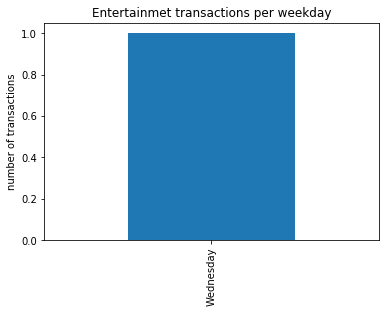

In [79]:
# On What week days do I spend on entertainment?

series = monthly_transactions[monthly_transactions.category == 'entertainment'].date_of_transaction.apply(lambda day: calendar.day_name[day.weekday()]).value_counts()
series.plot(kind='bar');
plt.ylabel('number of transactions')
plt.title('Entertainmet transactions per weekday');